# Notebook 3 (Preprocessing and modelling)

### Content
- Introduction
- Preprocessing
- Visualization after preprocessing is completed
- Modelling
- Evaluation of models
- Future work and recommendations

### Introduction

In this notebook, we will perform the preprocessing step to prepare the data for modelling. We aim to create a model that will be able to classify if a post belongs to the subreddit of Starbucks or DunkinDonuts. We will then evaluate the models with metrics such as accuracy score, recall score, precision score and F1 score

- Vectorizer: TF-IDF Vectorizer, Count Vectorizer

#### Models:
- Logistic Regression
- Random Forest Classification
- SVM 
- Ridge classification

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
    
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # RegexpTokenizer uses regex for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
import nltk

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline # to compactly pack multiple modeling operations
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.datasets import make_classification


# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

### Import the data

In [2]:
df = pd.read_csv('data/combined_df.csv')

In [3]:
print(df.shape)
df.head()

(9973, 4)


,Unnamed: 0,title,subreddit,words_in_sentence
0,0,My new favorite 50 stars drink! Caffe misto wi...,starbucks,23
1,1,How does your store handle partners buying mer...,starbucks,8
2,2,8am.. 🤦🏻‍♀️,starbucks,1
3,3,Looking for the gay male baristas?,starbucks,6
4,4,Reasons why I hate my job.,starbucks,6


In [4]:
df['starbucks']=df['subreddit'].map({'starbucks':1,'DunkinDonuts':0})
df.drop(columns=['subreddit','Unnamed: 0'] , axis = 1, inplace = True)
df.head()

,title,words_in_sentence,starbucks
0,My new favorite 50 stars drink! Caffe misto wi...,23,1
1,How does your store handle partners buying mer...,8,1
2,8am.. 🤦🏻‍♀️,1,1
3,Looking for the gay male baristas?,6,1
4,Reasons why I hate my job.,6,1


### Preprocessing

In [5]:
#Converting the text in 'title' to lowercase
df['title_cleaned'] = df['title'].apply(lambda x: " ".join(x.lower()
for x in x.split()))

In [6]:
#Remove numbers
df['title_cleaned'].replace('\d+', '', regex=True, inplace=True)

In [7]:
#Remove URL
df['title_cleaned'].str.replace('http\S+','')

/var/folders/rq/jvgm9dz559g9xyvpqqc2rlcm0000gn/T/ipykernel_65819/2256789894.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_cleaned'].str.replace('http\S+','')


0       my new favorite  stars drink! caffe misto with...
1       how does your store handle partners buying mer...
2                                              am.. 🤦🏻‍♀️
3                      looking for the gay male baristas?
4                              reasons why i hate my job.
                              ...                        
9968    dunkin’ reddit! please take a moment to fill o...
9969                            discontinuing strawberry?
9970                                      are these good?
9971                                     peach refresher?
9972    i’ve been going to dunkin forever and i really...
Name: title_cleaned, Length: 9973, dtype: object

In [8]:
#Remove punctuation
df['title_cleaned'] = df['title_cleaned'].str.replace(r'[^\w\s]+', '')

/var/folders/rq/jvgm9dz559g9xyvpqqc2rlcm0000gn/T/ipykernel_65819/628797242.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_cleaned'] = df['title_cleaned'].str.replace(r'[^\w\s]+', '')


In [11]:
#Lemmatized text in 'title_cleaned'
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

df['lem_words'] = df['title_cleaned'].apply(lambda x: tokenizer.tokenize(x)).apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lem_title'] = df['lem_words'].apply(lambda x: " ".join(x))

In [12]:
df.head()

,title,words_in_sentence,starbucks,title_cleaned,lem_words,lem_title
0,My new favorite 50 stars drink! Caffe misto wi...,23,1,my new favorite stars drink caffe misto with ...,"[my, new, favorite, star, drink, caffe, misto,...",my new favorite star drink caffe misto with oa...
1,How does your store handle partners buying mer...,8,1,how does your store handle partners buying mer...,"[how, doe, your, store, handle, partner, buyin...",how doe your store handle partner buying merch...
2,8am.. 🤦🏻‍♀️,1,1,am,[am],am
3,Looking for the gay male baristas?,6,1,looking for the gay male baristas,"[looking, for, the, gay, male, baristas]",looking for the gay male baristas
4,Reasons why I hate my job.,6,1,reasons why i hate my job,"[reason, why, i, hate, my, job]",reason why i hate my job


### Visualization for common words after lemmatizing text

In [13]:
cvec = CountVectorizer(stop_words='english', ngram_range = (1,1))

#Count Vectorize the rows that predicts Starbucks
sb_cvec = cvec.fit_transform(df[df['starbucks']==1]['lem_title'])
sb_cvec = pd.DataFrame(sb_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
sb_top_words = sb_cvec.sum().sort_values(ascending=False)
sb_top_60 = sb_top_words.head(60)

In [14]:
#Count Vectorize the rows that predicts Dunkin donuts
dd_cvec = cvec.fit_transform(df[df['starbucks']==0]['lem_title'])
dd_cvec = pd.DataFrame(dd_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
dd_top_words = dd_cvec.sum().sort_values(ascending=False)
dd_top_60 = dd_top_words.head(60)

Text(0.5, 0, 'Word Count')

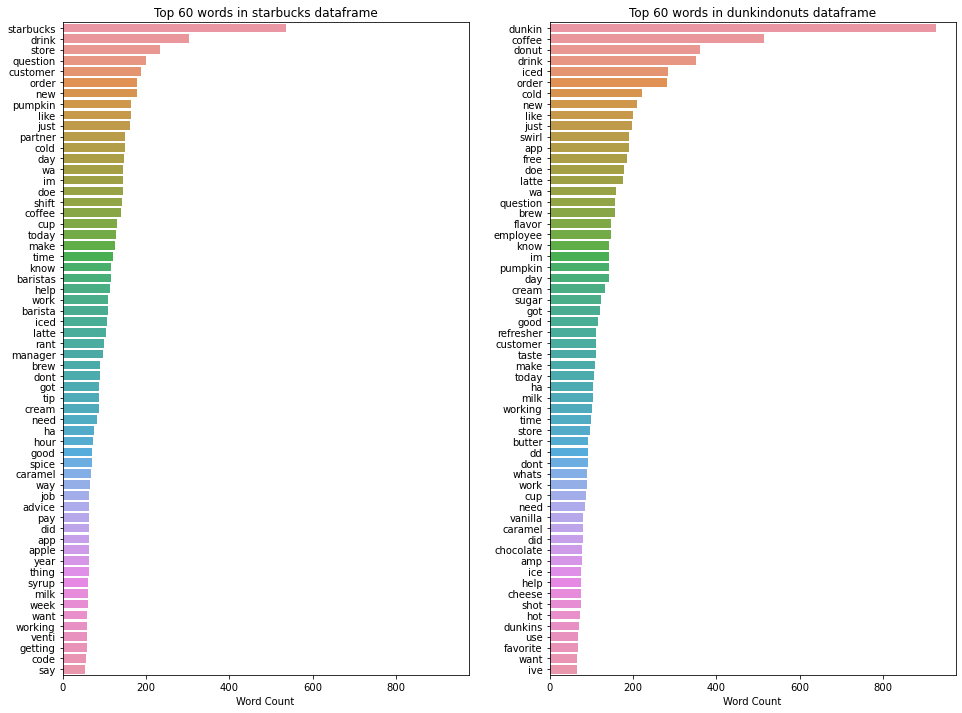

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,12), sharex = True)
                      
sns.barplot( x=sb_top_60, y=sb_top_60.index.values,ax=ax[0])
ax[0].set_title('Top 60 words in starbucks dataframe')
ax[0].set_xlabel('Word Count')               
sns.barplot( x=dd_top_60, y=dd_top_60.index.values,ax=ax[1])
ax[1].set_title('Top 60 words in dunkindonuts dataframe')
ax[1].set_xlabel('Word Count')  

We will remove additional stopwords which will not help us in identifying if a post belongs to starbucks or dunkin donuts subreddit
These sort of post includes
- Posts that contain the brand names ie. starbucks, dunkin
- other words that contain no meaning on it's own 

In [ ]:
stop_words = ['starbuck','thi','anyon','just','make','im','wa','doe','know','whi','got','ha','come','onli','say','dunkin','donut','get']


In [ ]:
final_stopwords = stopwords.words('english')
final_stopwords+=stop_words

In [ ]:
cvec = CountVectorizer(stop_words=final_stopwords, ngram_range = (1,1))

sb_cvec = cvec.fit_transform(df[df['starbucks']==1]['stem_title'])
sb_cvec = pd.DataFrame(sb_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
sb_top_words = sb_cvec.sum().sort_values(ascending=False)
sb_top_60 = sb_top_words.head(60)

In [ ]:
dd_cvec = cvec.fit_transform(df[df['starbucks']==0]['stem_title'])
dd_cvec = pd.DataFrame(dd_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
dd_top_words = dd_cvec.sum().sort_values(ascending=False)
dd_top_60 = dd_top_words.head(60)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,12), sharex = True)
                      
sns.barplot( x=sb_top_60, y=sb_top_60.index.values,ax=ax[0])
ax[0].set_title('Top 60 words in starbucks dataframe(revised after stopwords removed)')
ax[0].set_xlabel('Word Count')               
sns.barplot( x=dd_top_60, y=dd_top_60.index.values,ax=ax[1])
ax[1].set_title('Top 60 words in dunkindonuts dataframe(revised after stopwords removed)')
ax[1].set_xlabel('Word Count')  

In [ ]:
from wordcloud import WordCloud

#Quick check with WordCloud for most prominent words
wc_sb = WordCloud(background_color="white", colormap="Dark2",width=1000, height=800,
               max_words=50, random_state=42).generate_from_frequencies(sb_top_60)

plt.figure(figsize = (15,10) , facecolor = 'k')
plt.imshow(wc_sb)


In [ ]:
wc_dd = WordCloud(background_color="white", colormap="winter",width=1000, height=800,
               max_words=50, random_state=42).generate_from_frequencies(dd_top_60)

plt.figure(figsize = (15,10) , facecolor = 'k')
plt.imshow(wc_dd)

#### Bigrams

In [ ]:
cvec = CountVectorizer(stop_words=final_stopwords, ngram_range = (2,2))

sb_cvec = cvec.fit_transform(df[df['starbucks']==1]['stem_title'])
sb_cvec = pd.DataFrame(sb_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
sb_top_words = sb_cvec.sum().sort_values(ascending=False)
sb_top_60 = sb_top_words.head(60)

In [ ]:
dd_cvec = cvec.fit_transform(df[df['starbucks']==0]['stem_title'])
dd_cvec = pd.DataFrame(dd_cvec.toarray(),
                       columns = cvec.get_feature_names_out())
dd_top_words = dd_cvec.sum().sort_values(ascending=False)
dd_top_60 = dd_top_words.head(60)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (22,12), sharex = True)
                      
sns.barplot( x=sb_top_60, y=sb_top_60.index.values,ax=ax[0])
ax[0].set_title('Top 60 bigram words in starbucks dataframe(revised after stopwords removed)')
ax[0].set_xlabel('Word Count')               
sns.barplot( x=dd_top_60, y=dd_top_60.index.values,ax=ax[1])
ax[1].set_title('Top 60 bigram words in dunkindonuts dataframe(revised after stopwords removed)')
ax[1].set_xlabel('Word Count')  

Observations
- The words 'iced coffee' and 'cold brew' will likely classify the post to dunkin donuts

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokenized'] = df['stem_title'].apply(lambda x: tokenizer.tokenize(x))
df['words_in_title'] = df['tokenized'].apply(len)
df[df['words_in_title'] < 2]

We will remove all rows that are left with 1 word in title after stemming, this is because these post with 1 word might skew the performance of the model

In [ ]:
df = df[df['words_in_title']>=2]

In [ ]:
df.shape

Removed 306 rows

#### Saving dataframe for modelling

In [ ]:
df.to_csv('data/df_model.csv')

## Model


In [ ]:
X = df['stem_title']
y = df['starbucks']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=y)

In [ ]:
df['starbucks'].value_counts(normalize=True)

### Baseline model

Our basline model will be 0.5. There is only a 50% chance that this model will predict a text to be from starbucks subreddit.

#### TF-IDF and Logistic Regression

I choose to use TF-IDF vectorizer ahead of Count Vectorizer because TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

In [ ]:
tvec = TfidfVectorizer(stop_words=final_stopwords)

In [ ]:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                       columns=tvec.get_feature_names_out())

In [ ]:
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),
                       columns=tvec.get_feature_names_out())

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_tvec,y_train)

pred=lr.predict(X_test_tvec)

train_score = lr.score(X_train_tvec,y_train)
test_score = lr.score(X_test_tvec,y_test)
cv_score=cross_val_score(lr,X_train_tvec,y_train,cv=10).mean()

print(f'Training Score(Logreg) : {train_score}')
print(f'Testing Score(Logreg) : {test_score}')
print(f'Cross Validation Score(Logreg) : {cv_score}')
print('\n')

accuracy_lr = accuracy_score(y_test, pred)
recall_lr = recall_score(y_test,pred)
precision_lr = precision_score(y_test,pred)
f1_score_lr = f1_score(y_test,pred)

print(f'Accuracy score : {accuracy_lr}')
print(f'Recall score : {recall_lr}')
print(f'Precision score : {precision_lr}')
print(f'f1 score : {f1_score_lr}')

In [ ]:
#Exploring the Coefs that are strong indicators for model performance
coef_table = pd.DataFrame(list(X_train_tvec.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())
coef_table.head()

In [ ]:
highest_30_coef = coef_table.sort_values(by="Coefs",ascending = False).head(30)
lowest_30_coef = coef_table.sort_values(by="Coefs",ascending = False).tail(30)

In [ ]:
print("Top 30 words for predicting Starbucks")
highest_30_coef

Including additional stopwords to improve model performance

In [ ]:
final_stopwords = final_stopwords + ['star','sm','venti','grande','ssv','tall','asm','psl']

In [ ]:
print("Top 30 words for predicting DunkinDonuts")
lowest_30_coef

In [ ]:
final_stopwords = final_stopwords + ['tmobil','dunk','larg','dd']

In [ ]:
#Check for improvement of scores after removing stop words
tvec = TfidfVectorizer(stop_words=final_stopwords)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=y)

X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                       columns=tvec.get_feature_names_out())
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),
                       columns=tvec.get_feature_names_out())

lr.fit(X_train_tvec,y_train)

pred = lr.predict(X_test_tvec)

train_score = lr.score(X_train_tvec,y_train)
test_score = lr.score(X_test_tvec,y_test)
cv_score=cross_val_score(lr,X_train_tvec,y_train,cv=10).mean()

print(f'Training Score(Logreg) : {train_score}')
print(f'Testing Score(Logreg) : {test_score}')
print(f'Cross Validation Score(Logreg) : {cv_score}')
print('\n')

accuracy_lr = accuracy_score(y_test, pred)
recall_lr = recall_score(y_test,pred)
precision_lr = precision_score(y_test,pred)
f1_score_lr = f1_score(y_test,pred)

print(f'Accuracy score : {accuracy_lr}')
print(f'Recall score : {recall_lr}')
print(f'Precision score : {precision_lr}')
print(f'f1 score : {f1_score_lr}')

#Confusion Matrix Visualization
cm_lr = confusion_matrix(y_test, pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['starbucks', 'dunkindonuts'])
disp.plot();

*No Significant improvements in score after removing stopwords*

#### TF-IDF and Random Forest

In [ ]:
tvec = TfidfVectorizer(stop_words=final_stopwords)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=y)

X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                       columns=tvec.get_feature_names_out())
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),
                       columns=tvec.get_feature_names_out())

rf = RandomForestClassifier()

rf.fit(X_train_tvec,y_train)

pred = rf.predict(X_test_tvec)

train_score = rf.score(X_train_tvec,y_train)
test_score = rf.score(X_test_tvec,y_test)
cv_score = cross_val_score(rf,X_train_tvec,y_train,cv=10).mean()

print(f'Training Score(Random Forest) : {train_score}')
print(f'Testing Score(Random Forest) : {test_score}')
print(f'Cross Validation Score(Random Forest) : {cv_score}')
print('\n')

accuracy_rf = accuracy_score(y_test, pred)
recall_rf = recall_score(y_test,pred)
precision_rf = precision_score(y_test,pred)
f1_score_rf = f1_score(y_test,pred)

print(f'Accuracy score : {accuracy_rf}')
print(f'Recall score : {recall_rf}')
print(f'Precision score : {precision_rf}')
print(f'f1 score : {f1_score_rf}') 

#Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['starbucks', 'dunkindonuts'])
disp.plot();

Train set accuracy score is alot better than the test score, suggesting that this model might be overfitted.

|           | Baseline | Logistic Regression | Random Forest |
|-----------|----------|---------------------|---------------|
| Accuracy  | 0.5      | 0.725               | 0.699       |
| Precision |          | 0.718               | 0.706         |
| Recall    |          | 0.74                | 0.684         |
| F1        |          | 0.73                | 0.695        |

Logistic regression and random forest are performed here in order to serve as our new baseline model after beating our null model. We will then use the low code ML libray Pycaret to further explore other models which could potentially be an improvements on these 2 models.

### Modelling with Pycaret

In [ ]:
pyca_df = pd.concat([X_train_tvec, y_train.reset_index(drop=True)], axis=1)

In [ ]:
pyca_df.shape

In [ ]:
numeric_cols = list(pyca_df.columns)
numeric_cols = numeric_cols[:-1]

In [ ]:
from pycaret.classification import *

In [ ]:
model = setup(data = pyca_df, numeric_features=numeric_cols, target = 'starbucks', session_id=101)

In [ ]:
best_model = compare_models()

Model to be implemented:
- Logistic Regression
- SVM
- Ridge Classifier
- Random Forest Classifier

#### Logistic Regression with Pycaret

In [ ]:
lr_model = create_model('lr')

#### Tune model (Logistic Regression)

In [ ]:
tuned_lr = tune_model(lr_model, choose_better=True)

In [ ]:
plot_model(tuned_lr, plot = 'confusion_matrix')

#### SVM with Pycaret

In [ ]:
svm_model = create_model('svm')

#### Tune model (SVM)

In [ ]:
tuned_svm = tune_model(svm_model, choose_better=True)

In [ ]:
plot_model(svm_model, plot = 'confusion_matrix')

#### Ridge Classification with Pycaret

In [ ]:
ridge_model = create_model('ridge')

#### Tune model (Ridge)

In [ ]:
tuned_ridge = tune_model(ridge_model, choose_better=True)

In [ ]:
plot_model(tuned_ridge, plot = 'confusion_matrix')

#### Random Forest with Pycaret

In [ ]:
rf_model = create_model('rf')

#### Tune model (Random Forest)

In [ ]:
tuned_rf = tune_model(rf_model, choose_better=True)

In [ ]:
plot_model(rf_model, plot = 'confusion_matrix')

### Predict on test set

In [ ]:
predict_model(tuned_lr)

In [ ]:
predict_model(tuned_svm)

In [ ]:
predict_model(tuned_ridge)

In [ ]:
predict_model(rf_model)

|           | Logistic Regression | SVM    | Ridge Classification | Random Forest |
|-----------|---------------------|--------|----------------------|---------------|
| Accuracy  | 0.7187              | 0.7148 | 0.7241               | 0.7074        |
| Precision | 0.7155              | 0.7007 | 0.7194               | 0.7007        |
| Recall    | 0.7261              | 0.7498 | 0.7350               | 0.7241        |
| F1        | 0.7208              | 0.7244 | 0.7271               | 0.7122        |

It is observed that the ridge classification actually gave the best accuracy score for the test set.

|       | Logistic Regression (1st model) | SVM    | Ridge Classification | Random Forest |
|-------|---------------------------------|--------|----------------------|---------------|
| Train | 0.842                           | 0.7109 | 0.7141               | 0.7059        |
| Test  | 0.725                           | 0.7148 | 0.7241               | 0.7074        |

### Evaluating the models
The final scores are depicted as such. It is observed that the 4 models produced similar result. All of them have an approximate accuracy score of 0.7 with the Logistic regression model edge ahead very slightly with it's score of 0.725. Which means 72.5% accuracy of correctly classifying the reddit post. The Pycaret logistic model did not beat the score of the original logistic model, although from the scores it is suggested that the model is overfitted. The other 3 models have very similar output scores on the test set, with the ridge classification being the best model out of the other 3.

## Future work and recommendations
This section is for future work to improve on the current model. The logistic model is great for binary classification and relatively inexpensive to compute results, however this current model is overfitted. For future work, these points can be considered
- Use PDA to reduce the features
- XGBoost to improve the model performance on random forest (although this is computationally expensive and will take longer computing time)
- Collecting data on different seasons and put them through the same models for test because the logistic regression model might not be the best performer throughout the seasons

In [ ]:
coef_table = pd.DataFrame(list(X_train_tvec.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())
coef_table.head()
highest_10_coef = coef_table.sort_values(by="Coefs",ascending = False).head(10)
print("Top 10 words for starbucks")
highest_10_coef

Also this was observed, the top 10 words that are strong indicators that predict a post belongs to starbucks subreddit. Only frappuccino is the only food item on the list, which have to be crossed check with Dunkin Donuts menu and the word count of 'frappuccino' against the 5000 post scraped from reddit.

- Sentiment Analysis should also be performed on the top words to determine if these keywords could potentially lead to an improvement of customer's experience.

We embarked on this project to aim to solve achieve 2 objectives.
- To discover if the new products are actually getting any buzz through reddit
- To discover if it is of any value to Starbucks if reddit is a good source to validate our products in the future

The new products indeed created buzz, by being among the top keywords appearing before preprocessing. It is also worth noting that reddit can be a platform to validate the response of starbucks new products in the future as the comments and sentiments derive from them are very raw and authentic.

The top 10 words that strongly classify a post belonging to starbucks are
- barista
- partner
- frappuccino
- grand
- art
- transfer
- shaken
- flat
- siren
- store

None of which includes our festive drinks (pumpkin spice)
A good guess will be that the new products are no longer unique to starbucks and their competitors have already released similar products for this holiday.
*In the future, new products can likewise be validated in the same way. Starbucks can validate future new products that are unique to their competitors by harvesting the data among the text in reddit and check if the list of new keywords contains any words that are related to the new products.*